# Prepping the Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
import re

In [2]:
loan_data_raw = pd.read_csv('./data/SBAnational.csv')
loan_data_raw.head()

/tmp/ipykernel_85686/1931474034.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data_raw = pd.read_csv('./data/SBAnational.csv')


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [3]:
loan_data_raw.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')

In [4]:
loan_data_raw[loan_data_raw['ApprovalFY'] == '1976A'] = 1976
loan_data_raw['ApprovalFY'] = pd.to_numeric(loan_data_raw['ApprovalFY'])

# Verify
loan_data_raw['ApprovalFY'].unique()

array([1997, 1980, 2006, 1998, 1999, 2000, 2001, 1972, 2003, 2004, 1978,
       1979, 1981, 2005, 1962, 1982, 1965, 1966, 1983, 1973, 1984, 2007,
       1985, 1986, 1987, 2008, 1988, 2009, 1989, 1991, 1990, 1974, 2010,
       1967, 2011, 1992, 1993, 2002, 2012, 2013, 1994, 2014, 1975, 1977,
       1976, 1968, 1969, 1995, 1970, 1996, 1971])

In [5]:
def is_valid_date(date):
    # Regex pattern to match the date format d-Mon-YY or dd-Mon-YY
    pattern = r'^\d{1,2}-[A-Za-z]{3}-\d{2}$'
    str_date = str(date)
    return bool(re.match(pattern, str_date))

loan_data_raw = loan_data_raw[loan_data_raw['ApprovalDate'].apply(is_valid_date) & loan_data_raw['DisbursementDate'].apply(is_valid_date)]

In [6]:
loan_data_raw['ApprovalDate'] = pd.to_datetime(loan_data_raw['ApprovalDate'], format='%d-%b-%y')
loan_data_raw['ApprovalDate'] = (loan_data_raw['ApprovalDate'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1D')    

loan_data_raw['DisbursementDate'] = pd.to_datetime(loan_data_raw['DisbursementDate'], format='%d-%b-%y')
loan_data_raw['DisbursementDate'] = (loan_data_raw['DisbursementDate'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1D')

In [7]:
# Verify
loan_data_raw[['ApprovalDate', 'DisbursementDate']].head()

,ApprovalDate,DisbursementDate
0,9920,10650
1,9920,10012
2,9920,10226
3,9920,10042
4,9920,9995


In [8]:
def currency_to_double(series):
    return series.replace({'\$': '', ',': ''}, regex=True).astype(float)
    
currency_columns = ['DisbursementGross', 'GrAppv', 'SBA_Appv']
for col in currency_columns:
    loan_data_raw[col] = currency_to_double(loan_data_raw[col])

## Verify
loan_data_raw[currency_columns].head()

,DisbursementGross,GrAppv,SBA_Appv
0,60000.0,60000.0,48000.0
1,40000.0,40000.0,32000.0
2,287000.0,287000.0,215250.0
3,35000.0,35000.0,28000.0
4,229000.0,229000.0,229000.0


In [9]:
new_exist_case = lambda num: 'Existing' if num == 1 else 'New' if num == 2 else 'Unknown'
urban_rural_case = lambda num: 'Urban' if num == 1 else 'Rural' if num == 2 else 'Unknown'

loan_data_raw['NewExist'] = loan_data_raw['NewExist'].apply(new_exist_case)
loan_data_raw['UrbanRural'] = loan_data_raw['UrbanRural'].apply(urban_rural_case)

loan_data_raw[['NewExist', 'UrbanRural']].head()

,NewExist,UrbanRural
0,New,Unknown
1,New,Unknown
2,Existing,Unknown
3,Existing,Unknown
4,Existing,Unknown


In [10]:
trim_NAICS = lambda num: str(num)[:2]
loan_data_raw['NAICS'] = loan_data_raw['NAICS'].apply(trim_NAICS)
loan_data_raw['NAICS'].head()

0    45
1    72
2    62
3     0
4     0
Name: NAICS, dtype: object

In [11]:
Y_or_T = lambda char: 1 if char in ['Y', 'T'] else 0

loan_data_raw['RevLineCr'] = loan_data_raw['RevLineCr'].apply(Y_or_T)
loan_data_raw['LowDoc'] = loan_data_raw['LowDoc'].apply(Y_or_T)

loan_data_raw[['RevLineCr', 'LowDoc']].head()

,RevLineCr,LowDoc
0,0,1
1,0,1
2,0,0
3,0,1
4,0,0


In [12]:
loan_data = loan_data_raw.copy().dropna(subset=['MIS_Status'])
loan_data['MIS_Status'] = loan_data['MIS_Status'].apply(lambda status: 1 if status == 'CHGOFF' else 0)

# Verify
loan_data['MIS_Status'].head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    1
7    0
8    0
9    0
Name: MIS_Status, dtype: int64

In [13]:
drop_cols = ['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState', 'FranchiseCode', # business identity columns
             'ChgOffDate', 'BalanceGross', 'ChgOffPrinGr'] # other loan outcome columns

loan_data.drop(drop_cols, axis=1, inplace=True)
loan_data.head()

,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,MIS_Status,GrAppv,SBA_Appv
0,45,9920,1997,84,4,New,0,0,Unknown,0,1,10650,60000.0,0,60000.0,48000.0
1,72,9920,1997,60,2,New,0,0,Unknown,0,1,10012,40000.0,0,40000.0,32000.0
2,62,9920,1997,180,7,Existing,0,0,Unknown,0,0,10226,287000.0,0,287000.0,215250.0
3,0,9920,1997,60,2,Existing,0,0,Unknown,0,1,10042,35000.0,0,35000.0,28000.0
4,0,9920,1997,240,14,Existing,7,7,Unknown,0,0,9995,229000.0,0,229000.0,229000.0


# Random Forest Analysis

In [15]:
Y = loan_data['MIS_Status']
X = loan_data.drop('MIS_Status', axis=1) # Returns a copy of the data after dropping

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y,
                                                    test_size=0.2, random_state=42)

In [16]:
metric_funcs = [accuracy_score, precision_score, recall_score, f1_score]

def evaluate_results(metric_funcs, true_vals, predicted_vals, message):
    metric_vals = []
    
    print(message)
    for func in metric_funcs:
        evaluation = func(true_vals, predicted_vals)
        metric_vals.append(evaluation)
        print(func.__name__, evaluation, sep='\t')
        
    return metric_vals

In [17]:
### Function to plot overall evaluation metrics

import matplotlib.pyplot as plt
import numpy as np

def results_barplot(metric_funcs, metric_vals, title):
    fig = plt.figure(figsize = (10, 5))
    
    metric_names = []

    for func in metric_funcs:
        separator = func.__name__.index('_')
        name = func.__name__[:separator].capitalize()
        metric_names.append(name)

    plt.bar(metric_names, metric_vals)
    plt.yticks(np.arange(0.0, 1.0, 0.1))

    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.title(title)
    plt.xlabel("Evaluation Metric")
    plt.ylabel("Score")
    
    return fig

In [18]:
ordinal_cols = ['NewExist', 'UrbanRural']
scale_cols = ['ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob',
              'DisbursementDate', 'DisbursementGross', 'GrAppv', 'SBA_Appv', 'RevLineCr', 'LowDoc']

ordinal_categories = {
    'NewExist': ['Unknown', 'Existing', 'New'],
    'UrbanRural': ['Unknown', 'Urban', 'Rural']
}

# Encode non-numeric columns and scale columns of continuous values
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), ['NAICS']),
        ('ordinal', OrdinalEncoder(categories=[ordinal_categories[col] for col in ordinal_cols]), ordinal_cols),
        ('scaler', StandardScaler(), scale_cols)
])

RF_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'classifier__n_estimators': randint(low=10, high=100),
    'classifier__max_features': randint(low=1, high=8),
    'classifier__max_depth': randint(low=10, high=30),
    'classifier__min_samples_split': randint(low=1, high=100),
    'classifier__min_samples_leaf': randint(low=1, high=100)
}

rand_forest = RandomizedSearchCV(RF_pipeline, param_distributions=param_distribs,
                                 n_iter=50, cv=3, scoring='f1', random_state=42)

rand_forest.fit(X_train, Y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('onehot',
                                                                               OneHotEncoder(),
                                                                               ['NAICS']),
                                                                              ('ordinal',
                                                                               OrdinalEncoder(categories=[['Unknown',
                                                                                                           'Existing',
                                                                                                           'New'],
                                                                                                          ['Unknown',
                                                                                                           'Urban',
                                                                                                           'Rural']]),
                                                                               ['NewExist',
                                                                                'UrbanRural']),
                                                                              ('scaler',
                                                                               StandardScaler(),
                                                                               ['ApprovalDate',
                                                                                'ApprovalFY',
                                                                                'Term',
                                                                                'NoEmp',
                                                                                'CreateJob',
                                                                                'Retaine...
                                        'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78c9d1d19450>,
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78c9d1d18100>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78c9d31efca0>},
                   random_state=42, scoring='f1')

In [32]:
rand_forest.best_params_

{'classifier__max_depth': 18,
 'classifier__max_features': 7,
 'classifier__min_samples_leaf': 15,
 'classifier__min_samples_split': 90,
 'classifier__n_estimators': 51}

In [22]:
RF_classifier = rand_forest.best_estimator_

In [23]:
predictions = RF_classifier.predict(X_test)

metric_vals = evaluate_results(metric_funcs, Y_test, predictions, "Random Forest:")

Random Forest:
accuracy_score	0.9337527095577555
precision_score	0.8522243298378727
recall_score	0.7549538695665958
f1_score	0.8006455734507918


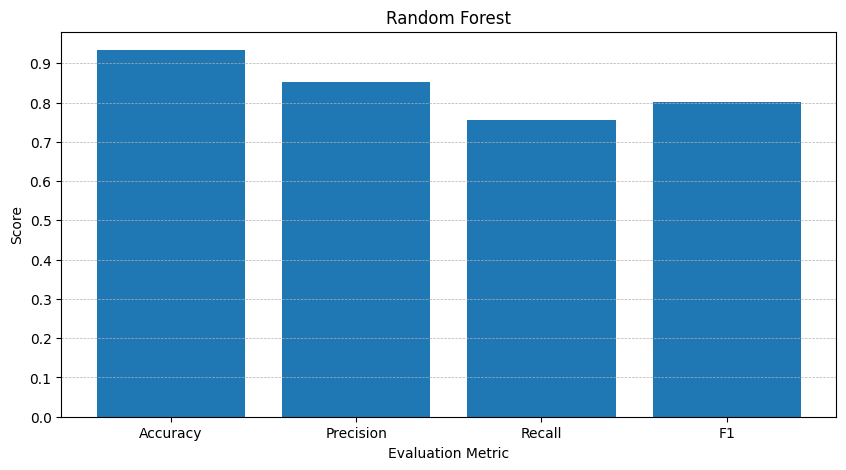

In [24]:
fig = results_barplot(metric_funcs, metric_vals, "Random Forest")

# Random Forest with Categories

In [25]:
### Function to plot compare metrics

def results_stacked_barplot(metric_funcs, metric_dict, title):
    fig = plt.subplots(figsize = (10, 5))
    bar_width = 0.2
    
    metric_names = []

    for func in metric_funcs:
        separator = func.__name__.index('_')
        name = func.__name__[:separator].capitalize()
        metric_names.append(name)

    bar1 = np.arange(len(metric_names))
    bar2 = [x + bar_width for x in bar1]
    bar3 = [x + bar_width for x in bar2]
    bars = [bar1, bar2, bar3]
    bar_iter = 0

    for category in metric_dict.keys():
        plt.bar(bars[bar_iter], metric_dict[category], width=bar_width, label=category)
        bar_iter += 1

    plt.yticks(np.arange(0.0, 1.0, 0.1))
    plt.xticks([r + bar_width for r in range(len(metric_names))], metric_names)

    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.title(title)
    plt.xlabel("Evaluation Metric")
    plt.ylabel("Score")
    plt.legend()
    
    return fig

In [26]:
### Making a copy of testing data and appending real values (Y) and predicted values
eval_X = X_test.copy()
eval_X['Outcome'] = Y_test.copy()
eval_X['Prediction'] = predictions.copy()

In [27]:
new_business_prediction = eval_X[eval_X['NewExist'] == 'New']['Prediction']
new_business_outcome = eval_X[eval_X['NewExist'] == 'New']['Outcome']

existing_business_prediction = eval_X[eval_X['NewExist'] == 'Existing']['Prediction']
existing_business_outcome = eval_X[eval_X['NewExist'] == 'Existing']['Outcome']

unknown_business_prediction = eval_X[eval_X['NewExist'] == 'Unknown']['Prediction']
unknown_business_outcome = eval_X[eval_X['NewExist'] == 'Unknown']['Outcome']

new_business_metrics = evaluate_results(metric_funcs, new_business_outcome, new_business_prediction, 
                                        "Random Forest - New Businesses")
print()
existing_business_metrics = evaluate_results(metric_funcs, existing_business_outcome, existing_business_prediction,
                                             "Random Forest - Existing Businesses")
print()
unknown_business_metrics = evaluate_results(metric_funcs, unknown_business_outcome, unknown_business_prediction,
                                            "Random Forest - Unknown Businesses")

Random Forest - New Businesses
accuracy_score	0.9205206921298142
precision_score	0.8362954902671986
recall_score	0.7242931937172775
f1_score	0.7762751809662758

Random Forest - Existing Businesses
accuracy_score	0.9388835755440995
precision_score	0.8588791700569569
recall_score	0.7685901519978156
f1_score	0.8112301263269129

Random Forest - Unknown Businesses
accuracy_score	0.9511111111111111
precision_score	1.0
recall_score	0.35294117647058826
f1_score	0.5217391304347826


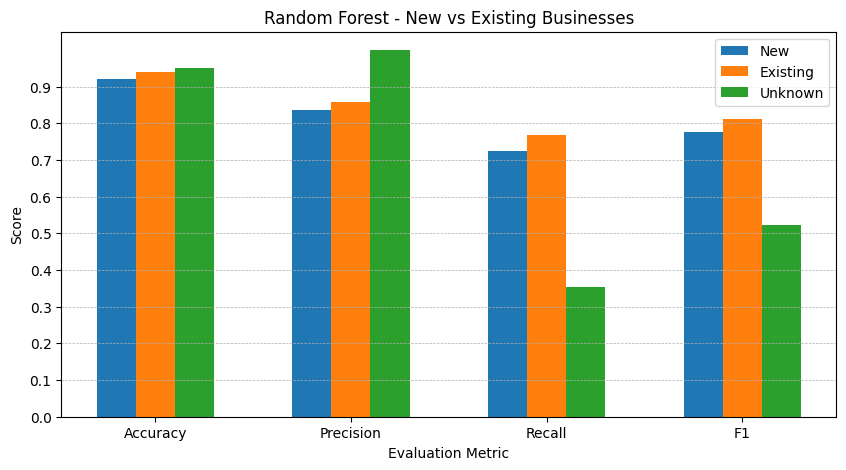

In [28]:
new_exist_metric_dict = {
    "New": new_business_metrics,
    "Existing": existing_business_metrics,
    "Unknown": unknown_business_metrics
}

fig = results_stacked_barplot(metric_funcs, new_exist_metric_dict, "Random Forest - New vs Existing Businesses")

In [29]:
urban_business_prediction = eval_X[eval_X['UrbanRural'] == 'Urban']['Prediction']
urban_business_outcome = eval_X[eval_X['UrbanRural'] == 'Urban']['Outcome']

rural_business_prediction = eval_X[eval_X['UrbanRural'] == 'Rural']['Prediction']
rural_business_outcome = eval_X[eval_X['UrbanRural'] == 'Rural']['Outcome']

unknown_business_prediction = eval_X[eval_X['UrbanRural'] == 'Unknown']['Prediction']
unknown_business_outcome = eval_X[eval_X['UrbanRural'] == 'Unknown']['Outcome']

urban_business_metrics = evaluate_results(metric_funcs, urban_business_outcome, urban_business_prediction,
                                          "Random Forest - Urban Businesses")
print()
rural_business_metrics = evaluate_results(metric_funcs, rural_business_outcome, rural_business_prediction,
                                          "Random Forest - Rural Businesses")
print()
unknown_business_metrics = evaluate_results(metric_funcs, unknown_business_outcome, unknown_business_prediction,
                                            "Random Forest - Unknown Businesses")

Random Forest - Urban Businesses
accuracy_score	0.9211501692996229
precision_score	0.8589079676569455
recall_score	0.8155624568668047
f1_score	0.8366741891234125

Random Forest - Rural Businesses
accuracy_score	0.9080278732340588
precision_score	0.7911826035150432
recall_score	0.6841834106130861
f1_score	0.7338030114656721

Random Forest - Unknown Businesses
accuracy_score	0.9604333855921022
precision_score	0.8747081712062257
recall_score	0.5023463687150838
f1_score	0.6381831085876508


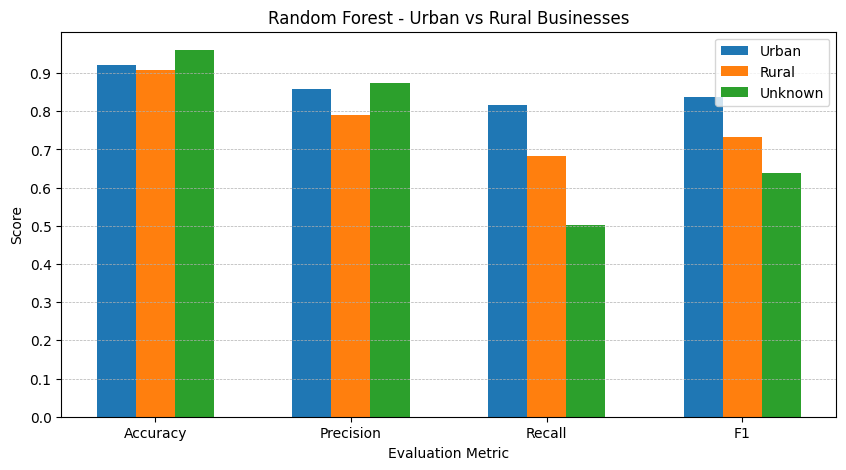

In [30]:
urban_rural_metric_dict = {
    "Urban": urban_business_metrics,
    "Rural": rural_business_metrics,
    "Unknown": unknown_business_metrics
}

fig = results_stacked_barplot(metric_funcs, urban_rural_metric_dict, "Random Forest - Urban vs Rural Businesses")

### Feature Importance

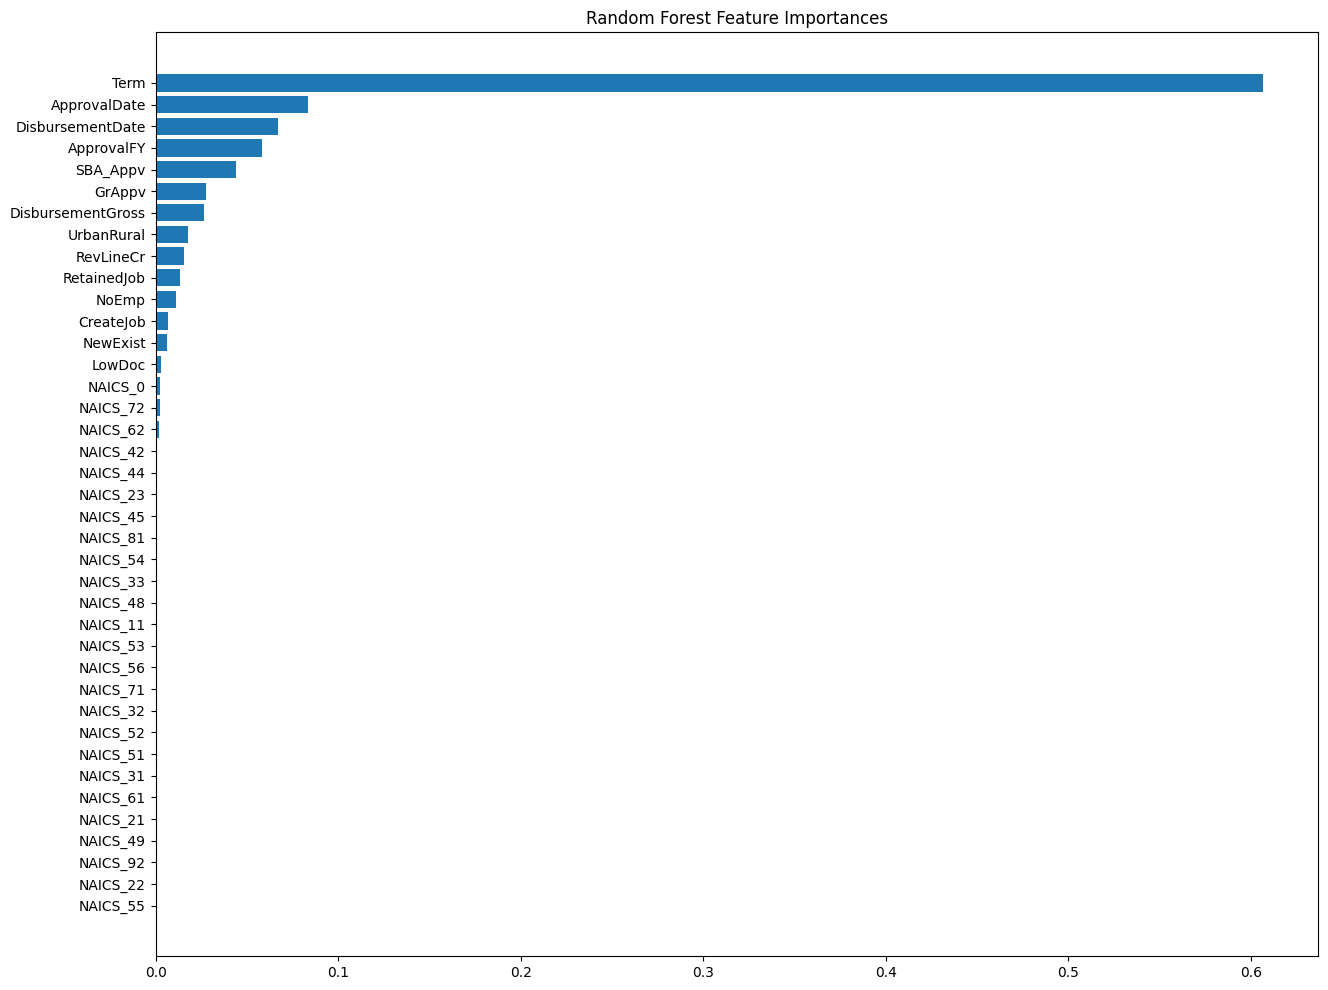

In [31]:
onehot_features = RF_classifier.named_steps['preprocessor'] \
                                .named_transformers_['onehot'] \
                                .get_feature_names_out(['NAICS'])

# Combine all names in the same order as the ColumnTransformer
all_features = np.concatenate([onehot_features, ordinal_cols, scale_cols])

importances = RF_classifier.named_steps['classifier'].feature_importances_

feat_importances = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(15, 12))
plt.barh(feat_importances['feature'], feat_importances['importance'])
plt.gca().invert_yaxis() 
plt.title('Random Forest Feature Importances')
plt.show()